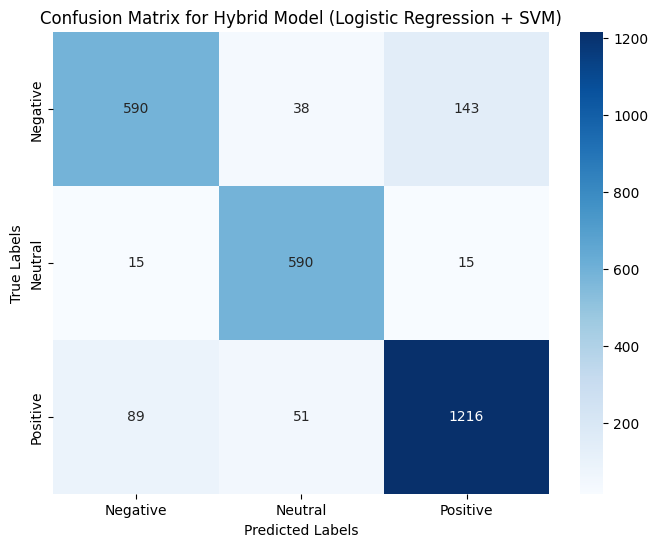


Metrics for Hybrid Model (Logistic Regression + SVM):

Negative Sentiment:
  Precision: 0.85
  Recall: 0.77
  F1-Score: 0.81
  Support: 771

Neutral Sentiment:
  Precision: 0.87
  Recall: 0.95
  F1-Score: 0.91
  Support: 620

Positive Sentiment:
  Precision: 0.89
  Recall: 0.90
  F1-Score: 0.89
  Support: 1356

Overall Metrics for Hybrid Model:
                                      Model  Accuracy (%)  Precision  \
0  Hybrid Model (Logistic Regression + SVM)     87.222424   0.868025   

     Recall  F1-Score  Support  
0  0.871203  0.868231     2747  


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'tweets1_processed.csv'
tweets_df = pd.read_csv(file_path)

# Encode the target variable
label_encoder = LabelEncoder()
tweets_df['sentiment_encoded'] = label_encoder.fit_transform(tweets_df['sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    tweets_df['processed_text'], 
    tweets_df['sentiment_encoded'], 
    test_size=0.2, 
    random_state=42
)

# Convert text data into numerical format using Bag of Words vectorization
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# Hyperparameter tuning for Logistic Regression
log_reg_param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [500, 1000, 2000]
}
log_reg_grid = GridSearchCV(LogisticRegression(), log_reg_param_grid, cv=5, scoring='accuracy')
log_reg_grid.fit(X_train_bow, y_train)

best_log_reg = LogisticRegression(**log_reg_grid.best_params_)
best_log_reg.fit(X_train_bow, y_train)

# Hyperparameter tuning for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=5, scoring='accuracy')
svm_grid.fit(X_train_bow, y_train)

best_svm = SVC(**svm_grid.best_params_, probability=True)  # Set probability=True for soft voting
best_svm.fit(X_train_bow, y_train)

# Create a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('log_reg', best_log_reg), ('svm', best_svm)],
    voting='soft',  # 'soft' uses probabilities for voting, 'hard' uses predicted class labels
    weights=[1, 2]  # You can adjust weights based on model performance
)

# Train the hybrid model
voting_clf.fit(X_train_bow, y_train)

# Predict on the test set
y_pred_voting = voting_clf.predict(X_test_bow)

# Evaluate the hybrid model
metrics_voting = precision_recall_fscore_support(y_test, y_pred_voting)
conf_matrix_voting = confusion_matrix(y_test, y_pred_voting)

# Plot confusion matrix for the hybrid model
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(conf_matrix_voting, "Hybrid Model (Logistic Regression + SVM)")

# Class-specific metrics for the hybrid model
def class_specific_metrics(y_test, y_pred):
    metrics = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1, 2])
    return {
        "Negative": {
            "Precision": metrics[0][0],
            "Recall": metrics[1][0],
            "F1-Score": metrics[2][0],
            "Support": metrics[3][0]
        },
        "Neutral": {
            "Precision": metrics[0][1],
            "Recall": metrics[1][1],
            "F1-Score": metrics[2][1],
            "Support": metrics[3][1]
        },
        "Positive": {
            "Precision": metrics[0][2],
            "Recall": metrics[1][2],
            "F1-Score": metrics[2][2],
            "Support": metrics[3][2]
        }
    }

voting_metrics = class_specific_metrics(y_test, y_pred_voting)

# Print the results in a structured format
def print_metrics(model_name, metrics):
    print(f"\nMetrics for {model_name}:")
    for sentiment, scores in metrics.items():
        print(f"\n{sentiment} Sentiment:")
        print(f"  Precision: {scores['Precision']:.2f}")
        print(f"  Recall: {scores['Recall']:.2f}")
        print(f"  F1-Score: {scores['F1-Score']:.2f}")
        print(f"  Support: {scores['Support']}")

print_metrics("Hybrid Model (Logistic Regression + SVM)", voting_metrics)

# Overall metrics for the hybrid model
overall_results_voting = {
    "Model": ["Hybrid Model (Logistic Regression + SVM)"],
    "Accuracy (%)": [
        accuracy_score(y_test, y_pred_voting) * 100
    ],
    "Precision": [
        metrics_voting[0].mean()
    ],
    "Recall": [
        metrics_voting[1].mean()
    ],
    "F1-Score": [
        metrics_voting[2].mean()
    ],
    "Support": [
        metrics_voting[3].sum()
    ]
}

overall_results_voting_df = pd.DataFrame(overall_results_voting)

print("\nOverall Metrics for Hybrid Model:")
print(overall_results_voting_df)
